In [4]:
!pip3 install scikit-surprise
!pip install papermill
!pip install recommenders[examples,gpu]
!pip install prettytable

In [77]:
import pandas as pd
import numpy as np
from recommenders.datasets.split_utils import min_rating_filter_pandas
import surprise
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions
from recommenders.datasets.python_splitters import python_random_split
from recommenders.utils.timer import Timer
from surprise.model_selection import train_test_split
# from surprise.accuracy import rmse
from surprise import accuracy
from recommenders.utils.python_utils import binarize
from collections import defaultdict
import random
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from prettytable import PrettyTable
import matplotlib.pyplot as plt


In [39]:
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [40]:
df = pd.DataFrame()
df[["userID", "itemID", "rating"]] = pd.read_json("../data/AMAZON_FASHION_5.71.268.json")[["userID", "itemID", "rating"]]
df.head()

,userID,itemID,rating
10,A3HX4X3TIABWOV,B000KPIHQ4,2
17,A3HX4X3TIABWOV,B000V0IBDM,2
24,A3QY3THQ42WSCQ,B000YFSR5G,1
25,AGZ5OOZVDO194,B000YFSR5G,5
26,A3GJ3DJU1RXOHN,B000YFSR4W,4


In [41]:
df.shape

(3010, 3)

In [42]:
df['rating'].value_counts()

5    2072
4     443
3     310
1     109
2      76
Name: rating, dtype: int64

In [43]:
df.drop_duplicates(inplace=True)

In [44]:
df.head

<bound method NDFrame.head of               userID      itemID  rating
10    A3HX4X3TIABWOV  B000KPIHQ4       2
17    A3HX4X3TIABWOV  B000V0IBDM       2
24    A3QY3THQ42WSCQ  B000YFSR5G       1
25     AGZ5OOZVDO194  B000YFSR5G       5
26    A3GJ3DJU1RXOHN  B000YFSR4W       4
...              ...         ...     ...
3171  A2077NII5H62R2  B005AGO4LU       5
3172  A2IBS6PIPAGAB5  B005AGO4LU       5
3173  A1GTC5EVSJNCQ8  B005AGO4LU       5
3174  A311XHHLM12MUT  B005AGO4LU       5
3175  A135SGOQMVWABQ  B005AGO4LU       5

[3010 rows x 3 columns]>

In [45]:
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

density = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d ratings from %d users on %d products (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], (1 - density) * 100))


After filtering, there are 3010 ratings from 388 users on 27 products (sparsity: 71.268%)


In [46]:
df.rating.value_counts()

5    2072
4     443
3     310
1     109
2      76
Name: rating, dtype: int64

In [47]:
df.shape

(3010, 3)

# Evaluation Functions

In [18]:
def GetTopN(predictions, n, minimumRating, criterion):
    topN = defaultdict(list)
    
    for index, row in predictions.iterrows():
        if (row[criterion] >= minimumRating):
            topN[(row.uid)].append(((row.iid), row[criterion]))

    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[(userID)] = ratings[:n]

    return topN

In [14]:
def DCG(query_relevancy_labels, k):
    # Use log with base 2
    value=min(k,len(query_relevancy_labels))
    sum1=0
    for i in range(value):
      sum1=sum1+((query_relevancy_labels[i])/(np.log2(2+i)))

    return sum1

def NDCG(query_relevancy_labels, k):
    sorted_list= np.sort(query_relevancy_labels)[::-1]
    dcg1 = DCG(query_relevancy_labels, k)
    dcg2 = DCG(sorted_list, k)
    if dcg2 == 0:
      return 0
    else:
      return dcg1/dcg2

In [15]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [16]:
def ndcg_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    dcg = dict()
    ndcg = dict()
    for uid, user_ratings in user_est_true.items():
        rel=[]

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        for _, true_r in user_ratings:
          if true_r>=threshold:
            rel.append(true_r)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        #print(rel)

        ndcg[uid] = NDCG(rel, k)

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        #recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return ndcg

# Initial Run of the Algorithm

In [61]:
train, test = python_random_split(df, 0.8)

In [62]:
train_set = surprise.Dataset.load_from_df(train, reader=Reader(rating_scale=(1,5)))
train_set

In [19]:
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)
reader = Reader(rating_scale=(1,5),)
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [20]:
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)
raw_ratings = data.raw_ratings
random.shuffle(raw_ratings)
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]
data.raw_ratings = A_raw_ratings

In [21]:
len(A_raw_ratings)

2408

In [22]:
len(B_raw_ratings)

602

In [63]:
param_grid = {'k': [1, 2, 5, 10, 20], 'min_k': [1, 2, 5, 10, 20]}
gs = GridSearchCV(KNNBaseline, param_grid, cv=5)
gs.fit(train_set)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

In [65]:
gs.best_params['rmse']['min_k']

2

In [57]:
sim_options = {'name': 'pearson_baseline',
               'user_based': False}
knn = KNNBaseline(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], sim_options=sim_options)
# trainset = data.build_full_trainset()
knn.fit(train_set)

# Compute biased accuracy on A
predictions = algo.test(train_set.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictions)

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)



Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.0843
Unbiased accuracy on B, RMSE: 0.1766


0.17664115977839356

In [67]:
sim_options = {'name': 'pearson_baseline',
               'user_based': False}
knn = KNNBaseline(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], sim_options=sim_options)
# trainset = data.build_full_trainset()
knn.fit(train_set.build_full_trainset())

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [75]:
predictions = predict(knn, test, usercol='userID', itemcol='itemID')
predictions.head()

,userID,itemID,prediction
0,ASOSP4VAUDB7I,B014IBJKNO,4.006458
1,A140XVPLRQYKYY,B0058YEJ5K,4.003481
2,ATSUXY7ASCGPY,B014IBJKNO,4.004878
3,A1S4O68F0UG4GA,B001IKJOLW,4.993395
4,A2CP5A30XO5JUO,B009MA34NY,5.000000


In [72]:
with Timer() as test_time:
    all_predictions = compute_ranking_predictions(knn, df, usercol='userID', itemcol='itemID', remove_seen=True)
    
print("Took {} seconds for prediction.".format(test_time.interval))

Took 0.17833538299964857 seconds for prediction.


In [79]:
all_predictions

,userID,itemID,prediction
3010,A3HX4X3TIABWOV,B000YFSR5G,4.021916
3011,A3HX4X3TIABWOV,B000YFSR4W,4.007633
3012,A3HX4X3TIABWOV,B0014F8TIU,4.306704
3013,A3HX4X3TIABWOV,B0017LD0BM,4.023662
3014,A3HX4X3TIABWOV,B0017LGD34,3.960704
...,...,...,...
10471,A135SGOQMVWABQ,B00ZUA6AJK,4.389226
10472,A135SGOQMVWABQ,B01595OS62,4.520902
10473,A135SGOQMVWABQ,B016XAJLVO,4.520902
10474,A135SGOQMVWABQ,B01H7KY678,4.490405


In [78]:
eval_rmse = rmse(test, predictions)
eval_mae = mae(test, predictions)
eval_rsquared = rsquared(test, predictions)
eval_exp_var = exp_var(test, predictions)

k = 10
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)


print("RMSE:\t\t%f" % eval_rmse,
      "MAE:\t\t%f" % eval_mae,
      "rsquared:\t%f" % eval_rsquared,
      "exp var:\t%f" % eval_exp_var, sep='\n')

print('----')

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

RMSE:		0.139930
MAE:		0.020032
rsquared:	0.981423
exp var:	0.981431
----
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000


In [35]:
newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k"]) 
# precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=10)
# ndcg_val = ndcg_at_k(predictions, k=10, threshold=4)
# precisionk=(sum(prec for prec in precisions.values()) / len(precisions))
# recallk=(sum(rec for rec in recalls.values()) / len(recalls))
ndcgk=(sum(nd for nd in ndcg_val.values()) / len(ndcg_val))
sparse=0.70
newTable.add_row(["KNN_Baseline", sparse, 0 , 0, eval_ndcg])   
print(newTable)

NameError: name 'test' is not defined

# Model Pipeline Functions

In [25]:
def _print(message, verbose):
    if verbose:
        print(message)
    

def load_dataset(fp):
    df = pd.DataFrame()
    try:
        df[["userID", "itemID", "rating", "timestamp"]] = pd.read_json(fp)[["reviewerID", "asin", "overall", "unixReviewTime"]]
    except:
        df = pd.read_json(fp)
    return df


def filter_to_sparsity(df, sparsity_percentage, verbose = False):
    # Obtain both usercount and itemcount after filtering
    usercount = df[['userID']].groupby('userID', as_index = False).size()
    itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))

    _print(f"After filtering, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    
    drop_item_ratings = int(-((1-sparsity_percentage) * (usercount.shape[0] * itemcount.shape[0]) - df.shape[0]))
    print(f"To obtain a sparsity of {sparsity_percentage * 100}% we need to drop {drop_item_ratings} ratings")
    drop_indices = np.random.choice(df.index, size=drop_item_ratings)
    df.drop(drop_indices, inplace=True)

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))
    _print(f"After dropping cells, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    return df


In [26]:
def build_data(df):
    
    my_seed = 0
    random.seed(my_seed)
    np.random.seed(my_seed)
    
    reader = Reader(rating_scale=(1,5))
    data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)
    return data

In [27]:
def data_loading_pipeline(fp, sparsity_percentage=None, with_writing=False):
    """
    fp: str = Filepointer to desired user-item-ratings json.
    sparsity_percentage: float = value between 0-1.
    """
    df = load_dataset(fp)
    #df = filter_on_minimal_ratings(df)
    df = filter_to_sparsity(df, sparsity_percentage)
    data = build_data(df)
    
    return data




In [28]:
def create_split(i, data):
    np.random.seed(i)


    raw_ratings = data.raw_ratings
    random.shuffle(raw_ratings)
    threshold = int(.8 * len(raw_ratings))
    A_raw_ratings = raw_ratings[:threshold]
    B_raw_ratings = raw_ratings[threshold:]
    data.raw_ratings = A_raw_ratings
    return A_raw_ratings, B_raw_ratings, data.raw_ratings

In [29]:
metrics_at_sparsity_levels = dict()

In [30]:
for i in range(20):
    pr=[]
    re=[]
    nd=[]
    sparsity_percentage = 0.75
    data = data_loading_pipeline("AMAZON_FASHION_5.json", sparsity_percentage)

    A_raw_ratings, B_raw_ratings, data.raw_ratings = create_split(i, data)


    sim_options = {'name': 'pearson_baseline',
               'user_based': True  
               }

    param_grid = {'k': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'min_k': [10, 20, 30, 40, 50, 60, 70, 80, 90]
              }
    gs = GridSearchCV(KNNBaseline, param_grid, cv=3)

    gs.fit(data)
    algo=KNNBaseline(sim_options=sim_options, k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], verbose=False)

    trainset = data.build_full_trainset()
    algo.fit(trainset)

    # Compute biased accuracy on A
    predictions = algo.test(trainset.build_testset())
    print('Biased accuracy on A,', end='   ')
    accuracy.rmse(predictions)

    # Compute unbiased accuracy on B
    testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
    predictions = algo.test(testset)
    print('Unbiased accuracy on B,', end=' ')
    accuracy.rmse(predictions)



    newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k"]) 
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)
    ndcg_val = ndcg_at_k(predictions, k=10, threshold=4)
    precisionk=(sum(prec for prec in precisions.values()) / len(precisions))
    recallk=(sum(rec for rec in recalls.values()) / len(recalls))
    ndcgk=(sum(nd for nd in ndcg_val.values()) / len(ndcg_val))
    pr.append(precisionk)
    re.append(recallk)
    nd.append(ndcgk)
ndcgk = sum(nd) / len(nd)
precisionk = sum(pr) / len(pr)
recallk = sum(re) / len(re)
metrics_at_sparsity_levels[str(sparsity_percentage)] = {
                                                        "ndcg": ndcgk,
                                                        "precision": precisionk,
                                                        "recall": recallk}
newTable.add_row(["KNN_Baseline", sparsity_percentage, precisionk , recallk, ndcgk])   
print(newTable)


Streaming output truncated to the last 5000 lines.
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computin

In [32]:
for i in range(20):
    pr=[]
    re=[]
    nd=[]
    sparsity_percentage = 0.8
    data = data_loading_pipeline("AMAZON_FASHION_5.json", sparsity_percentage)

    A_raw_ratings, B_raw_ratings, data.raw_ratings = create_split(i, data)

    sim_options = {'name': 'pearson_baseline',
               'user_based': True  
               }

    param_grid = {'k': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'min_k': [10, 20, 30, 40, 50, 60, 70, 80, 90]
              }
    gs = GridSearchCV(KNNBaseline, param_grid, cv=3)

    gs.fit(data)
    algo=KNNBaseline(sim_options=sim_options, k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'])

    trainset = data.build_full_trainset()
    algo.fit(trainset)

    # Compute biased accuracy on A
    predictions = algo.test(trainset.build_testset())
    print('Biased accuracy on A,', end='   ')
    accuracy.rmse(predictions)

    # Compute unbiased accuracy on B
    testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
    predictions = algo.test(testset)
    print('Unbiased accuracy on B,', end=' ')
    accuracy.rmse(predictions)



    newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k"]) 
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)
    ndcg_val = ndcg_at_k(predictions, k=10, threshold=4)
    precisionk=(sum(prec for prec in precisions.values()) / len(precisions))
    recallk=(sum(rec for rec in recalls.values()) / len(recalls))
    ndcgk=(sum(nd for nd in ndcg_val.values()) / len(ndcg_val))
    pr.append(precisionk)
    re.append(recallk)
    nd.append(ndcgk)
ndcgk = sum(nd) / len(nd)
precisionk = sum(pr) / len(pr)
recallk = sum(re) / len(re)
metrics_at_sparsity_levels[str(sparsity_percentage)] = {
                                                        "ndcg": ndcgk,
                                                        "precision": precisionk,
                                                        "recall": recallk}
newTable.add_row(["KNN_Baseline", sparsity_percentage, precisionk , recallk, ndcgk])   
print(newTable)


Streaming output truncated to the last 5000 lines.
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computin

In [33]:
for i in range(20):
    pr=[]
    re=[]
    nd=[]
    sparsity_percentage = 0.85
    data = data_loading_pipeline("AMAZON_FASHION_5.json", sparsity_percentage)





    A_raw_ratings, B_raw_ratings, data.raw_ratings = create_split(i, data)

    sim_options = {'name': 'pearson_baseline',
               'user_based': True  
               }

    param_grid = {'k': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'min_k': [10, 20, 30, 40, 50, 60, 70, 80, 90]
              }
    gs = GridSearchCV(KNNBaseline, param_grid, cv=3)

    gs.fit(data)
    algo=KNNBaseline(sim_options=sim_options, k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'])

    trainset = data.build_full_trainset()
    algo.fit(trainset)

    # Compute biased accuracy on A
    predictions = algo.test(trainset.build_testset())
    print('Biased accuracy on A,', end='   ')
    accuracy.rmse(predictions)

    # Compute unbiased accuracy on B
    testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
    predictions = algo.test(testset)
    print('Unbiased accuracy on B,', end=' ')
    accuracy.rmse(predictions)



    newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k"]) 
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)
    ndcg_val = ndcg_at_k(predictions, k=10, threshold=4)
    precisionk=(sum(prec for prec in precisions.values()) / len(precisions))
    recallk=(sum(rec for rec in recalls.values()) / len(recalls))
    ndcgk=(sum(nd for nd in ndcg_val.values()) / len(ndcg_val))
    pr.append(precisionk)
    re.append(recallk)
    nd.append(ndcgk)
ndcgk = sum(nd) / len(nd)
precisionk = sum(pr) / len(pr)
recallk = sum(re) / len(re)
metrics_at_sparsity_levels[str(sparsity_percentage)] = {
                                                        "ndcg": ndcgk,
                                                        "precision": precisionk,
                                                        "recall": recallk}
newTable.add_row(["KNN_Baseline", sparsity_percentage, precisionk , recallk, ndcgk])   
print(newTable)

Streaming output truncated to the last 5000 lines.
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computin

In [34]:
for i in range(20):
    pr=[]
    re=[]
    nd=[]
    sparsity_percentage = 0.9
    data = data_loading_pipeline("AMAZON_FASHION_5.json", sparsity_percentage)



    A_raw_ratings, B_raw_ratings, data.raw_ratings = create_split(i, data)

    sim_options = {'name': 'pearson_baseline',
               'user_based': True  
               }

    param_grid = {'k': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'min_k': [10, 20, 30, 40, 50, 60, 70, 80, 90]
              }
    gs = GridSearchCV(KNNBaseline, param_grid, cv=3)

    gs.fit(data)
    algo=KNNBaseline(sim_options=sim_options, k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'])

    trainset = data.build_full_trainset()
    algo.fit(trainset)

    # Compute biased accuracy on A
    predictions = algo.test(trainset.build_testset())
    print('Biased accuracy on A,', end='   ')
    accuracy.rmse(predictions)

    # Compute unbiased accuracy on B
    testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
    predictions = algo.test(testset)
    print('Unbiased accuracy on B,', end=' ')
    accuracy.rmse(predictions)



    newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k"]) 
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)
    ndcg_val = ndcg_at_k(predictions, k=10, threshold=4)
    precisionk=(sum(prec for prec in precisions.values()) / len(precisions))
    recallk=(sum(rec for rec in recalls.values()) / len(recalls))
    ndcgk=(sum(nd for nd in ndcg_val.values()) / len(ndcg_val))
    pr.append(precisionk)
    re.append(recallk)
    nd.append(ndcgk)
ndcgk = sum(nd) / len(nd)
precisionk = sum(pr) / len(pr)
recallk = sum(re) / len(re)
metrics_at_sparsity_levels[str(sparsity_percentage)] = {
                                                        "ndcg": ndcgk,
                                                        "precision": precisionk,
                                                        "recall": recallk}
newTable.add_row(["KNN_Baseline", sparsity_percentage, precisionk , recallk, ndcgk])   
print(newTable)

Streaming output truncated to the last 5000 lines.
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computin

In [35]:
for i in range(20):
    pr=[]
    re=[]
    nd=[]
    sparsity_percentage = 0.95
    data = data_loading_pipeline("AMAZON_FASHION_5.json", sparsity_percentage)



    A_raw_ratings, B_raw_ratings, data.raw_ratings = create_split(i, data)

    sim_options = {'name': 'pearson_baseline',
               'user_based': True  
               }

    param_grid = {'k': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'min_k': [10, 20, 30, 40, 50, 60, 70, 80, 90]
              }
    gs = GridSearchCV(KNNBaseline, param_grid, cv=3)

    gs.fit(data)
    algo=KNNBaseline(sim_options=sim_options, k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'])

    trainset = data.build_full_trainset()
    algo.fit(trainset)

    # Compute biased accuracy on A
    predictions = algo.test(trainset.build_testset())
    print('Biased accuracy on A,', end='   ')
    accuracy.rmse(predictions)

    # Compute unbiased accuracy on B
    testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
    predictions = algo.test(testset)
    print('Unbiased accuracy on B,', end=' ')
    accuracy.rmse(predictions)



    newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k"]) 
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)
    ndcg_val = ndcg_at_k(predictions, k=10, threshold=4)
    precisionk=(sum(prec for prec in precisions.values()) / len(precisions))
    recallk=(sum(rec for rec in recalls.values()) / len(recalls))
    ndcgk=(sum(nd for nd in ndcg_val.values()) / len(ndcg_val))
    pr.append(precisionk)
    re.append(recallk)
    nd.append(ndcgk)
ndcgk = sum(nd) / len(nd)
precisionk = sum(pr) / len(pr)
recallk = sum(re) / len(re)
metrics_at_sparsity_levels[str(sparsity_percentage)] = {
                                                        "ndcg": ndcgk,
                                                        "precision": precisionk,
                                                        "recall": recallk}
newTable.add_row(["KNN_Baseline", sparsity_percentage, precisionk , recallk, ndcgk])   
print(newTable)

Streaming output truncated to the last 5000 lines.
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computin

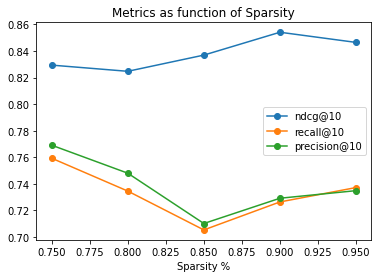

In [36]:
import matplotlib.pyplot as plt
sparsity_levels = list(map(lambda x: float(x), metrics_at_sparsity_levels))
plt.plot(sparsity_levels, list(map(lambda x: x['ndcg'], metrics_at_sparsity_levels.values())), label="ndcg@10", marker = "o")
#plt.plot(sparsity_levels, list(map(lambda x: x['map'], metrics_at_sparsity_levels.values())), label="map@10", marker = "o")
plt.plot(sparsity_levels, list(map(lambda x: x['recall'], metrics_at_sparsity_levels.values())), label="recall@10", marker = "o")
plt.plot(sparsity_levels, list(map(lambda x: x['precision'], metrics_at_sparsity_levels.values())), label="precision@10", marker = "o")

plt.title("Metrics as function of Sparsity")
plt.xlabel("Sparsity %")
plt.legend()
plt.savefig("../metrics_over_sparsity.png")
plt.show()